# Chapter 10. RNN - 딥러닝을 이용한 문서 분류

## 10.3. RNN을 이용한 문서 분류 - NLTK 영화 리뷰 감성분석

### 10.3.1 워드 임베딩을 위한 데이터 준비


In [1]:
from nltk.corpus import movie_reviews
import nltk
nltk.download('movie_reviews')
fileids = movie_reviews.fileids() #movie review data에서 file id를 가져옴
reviews = [movie_reviews.raw(fileid) for fileid in fileids] #file id를 이용해 raw text file을 가져옴
categories = [movie_reviews.categories(fileid)[0] for fileid in fileids]
#file id를 이용해 label로 사용할 category 즉 positive와 negative 정보를 순서대로 가져옴

print('Reviews count:', len(reviews))
print('Length of the first review:', len(reviews[0]))
print('Labels:', set(categories))

[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.


Reviews count: 2000
Length of the first review: 4043
Labels: {'neg', 'pos'}


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
np.random.seed(7)
tf.random.set_seed(7)

max_words = 10000 #사용할 단어의 수

# 빈도가 높은 10000개의 단어를 선택하도록 객체 생성
tokenizer = Tokenizer(num_words=max_words, oov_token='UNK')

tokenizer.fit_on_texts(reviews) #단어 인덱스 구축

#만들어진 단어 인덱스를 이용해 문서들을 변환
X = tokenizer.texts_to_sequences(reviews)

print('Lengths of first 10 documents:', [len(doc) for doc in X[:10]])

Lengths of first 10 documents: [710, 240, 486, 479, 733, 671, 550, 584, 702, 776]


In [3]:
print("Index of 'the':", tokenizer.word_index["the"])
print("Index of 'review':", tokenizer.word_index["review"])
print("Index of out-of-vocabulary words:", tokenizer.word_index["UNK"])

Index of 'the': 2
Index of 'review': 466
Index of out-of-vocabulary words: 1


In [4]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

maxlen = 500 #문서의 단어 수를 제한

# 문서의 단어 수가 500보다 작으면 0을 채우고, 크면 잘라냄
# 잘라낼 때, 앞을 자를 지, 뒤를 자를 지 선택할 수 있음. 앞을 자르고 뒷부분을 쓰고자 하면 'pre' 선택
X = pad_sequences(X, maxlen=maxlen, truncating='pre')

In [5]:
import numpy as np

# label을 0, 1의 값으로 변환
label_dict = {'pos':1, 'neg':0}
y = np.array([label_dict[c] for c in categories])
print(set(y))

{np.int64(0), np.int64(1)}


In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

print('Train set count:', len(X_train))
print('Test set count:', len(X_test))
print('Test samples:', y_test[:20])

Train set count: 1600
Test set count: 400
Test samples: [0 1 1 0 1 1 0 0 0 0 1 1 0 0 1 0 0 1 1 1]


### 10.3.2 RNN이 아닌 일반적인 신경망 모형을 이용한 분류


In [18]:
# 케라스 모형 생성 및 학습
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Embedding

model = Sequential([ #순차적 모형
    Embedding(max_words, 32, input_length=maxlen), #word embedding layer 생성
    # max_words는 one-hot encoding을 할 때의 vector 크기가 됨 - 사용된 단어의 수만큼
    # 각 단어는 32 크기의 dense vector로 embedding 됨
    # input_length는 한 document의 단어 수로 표현
    # 이 과정을 거치면 각 document는 (maxlen, 32)의 2차원 행렬이 됨 - 즉 word의 sequence가 됨

    Flatten(), # 2차원 행렬을 1차원으로 펼침
    Dense(1, activation='sigmoid') #binary logistic regression을 수행
])

model.summary() #모델의 요약정보 출력

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [19]:
# 모형의 optimizer와 loss function 등을 지정
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
# 학습을 수행
history = model.fit(X_train, y_train,
                    epochs=10,
                    verbose=1,
                    validation_split=0.2)

Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - acc: 0.4917 - loss: 0.6936 - val_acc: 0.5469 - val_loss: 0.6901
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.9291 - loss: 0.6123 - val_acc: 0.5875 - val_loss: 0.6846
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - acc: 0.9717 - loss: 0.5146 - val_acc: 0.5844 - val_loss: 0.6732
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.9869 - loss: 0.3826 - val_acc: 0.6125 - val_loss: 0.6573
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.9941 - loss: 0.2499 - val_acc: 0.6156 - val_loss: 0.6439
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.9952 - loss: 0.1476 - val_acc: 0.6344 - val_loss: 0.6382
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.9973 - loss: 0.0817 - val_acc: 0.6406 - val_loss: 0.6421
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 1.0000 - loss: 0.0437 - val_acc: 0.6438 - val_loss: 0.6559
Epoch 9/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 1.0000 - loss:

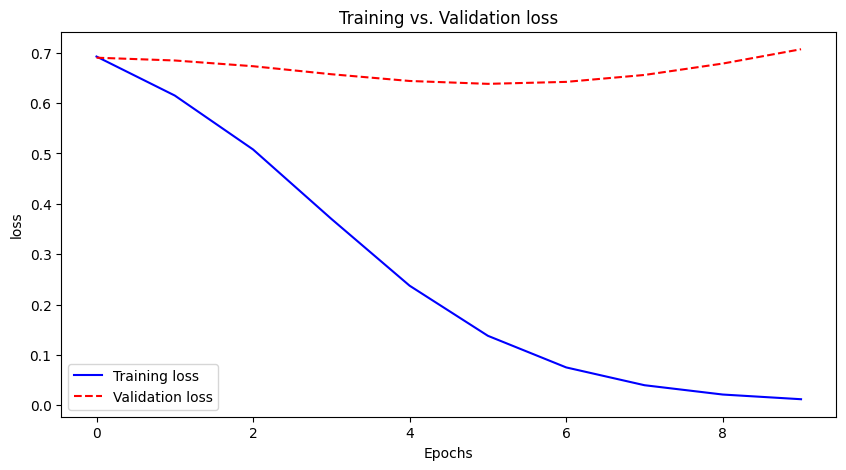

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_results(history, metric):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history[metric], 'b', label='Training '+metric)
    plt.plot(history.history['val_'+metric], 'r--', label='Validation '+metric)
    plt.title('Training vs. Validation '+metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.show()

plot_results(history, 'loss')

In [21]:
#테스트 셋으로 학습된 모형의 성능을 평가
score = model.evaluate(X_test, y_test)
print(f'#Test accuracy:{score[1]:.3f}')

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - acc: 0.6448 - loss: 0.6902
#Test accuracy:0.635


### 10.3.3 문서의 순서정보를 활용하는 RNN 기반 문서분류


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - acc: 0.4892 - loss: 0.7004 - val_acc: 0.4875 - val_loss: 0.6985
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - acc: 0.5126 - loss: 0.6849 - val_acc: 0.4781 - val_loss: 0.6978
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - acc: 0.5460 - loss: 0.6736 - val_acc: 0.4812 - val_loss: 0.6975
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - acc: 0.6109 - loss: 0.6607 - val_acc: 0.4875 - val_loss: 0.6973
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - acc: 0.6587 - loss: 0.6439 - val_acc: 0.4875 - val_loss: 0.6969
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - acc: 0.7395 - loss: 0.6214 - val_acc: 0.4781 - val_loss: 0.6978
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - acc: 0.8227 - loss: 0.5912 - val_acc: 0.5000 - val_loss: 0.7000
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - acc: 0.8697 - loss: 0.5523 - val_acc: 0.4875 - val_loss: 0.7047
Epoch 9/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - acc: 0.9180

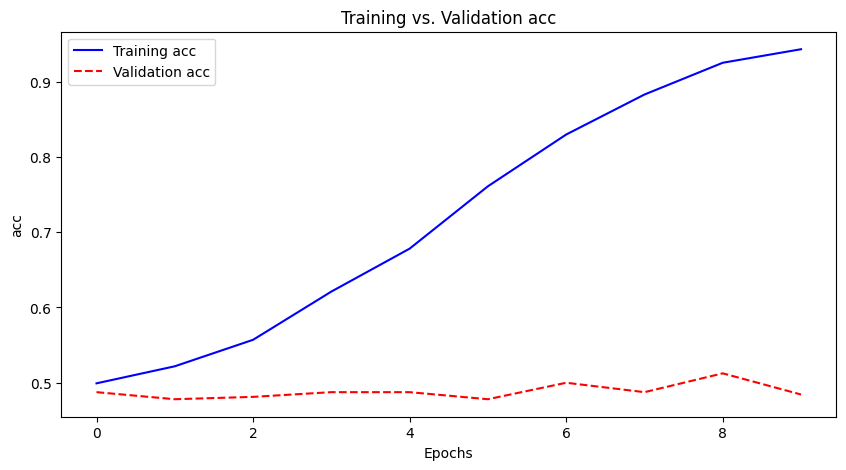

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - acc: 0.5291 - loss: 0.6932
#Test accuracy:0.530


In [23]:
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Embedding(max_words, 32),
    SimpleRNN(32), # 펼쳐서 flat하게 만드는 대신 RNN 모형을 사용, maxlen만큼의 시계열 데이터
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.summary()

adam = Adam(learning_rate=1e-4)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train,
                    epochs=10,
                    verbose=1,
                    validation_split=0.2)

plot_results(history, 'acc')
#테스트 셋으로 학습된 모형의 성능을 평가
score = model.evaluate(X_test, y_test)
print(f'#Test accuracy:{score[1]:.3f}')

## 10.4. LSTM, Bi-LSTM과 GRU를 이용한 성능 개선


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/8
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - acc: 0.4643 - loss: 0.6934 - val_acc: 0.5031 - val_loss: 0.6930
Epoch 2/8
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - acc: 0.5864 - loss: 0.6922 - val_acc: 0.5063 - val_loss: 0.6929
Epoch 3/8
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - acc: 0.6382 - loss: 0.6912 - val_acc: 0.5250 - val_loss: 0.6927
Epoch 4/8
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - acc: 0.6666 - loss: 0.6896 - val_acc: 0.5375 - val_loss: 0.6923
Epoch 5/8
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - acc: 0.6993 - loss: 0.6864 - val_acc: 0.5531 - val_loss: 0.6908
Epoch 6/8
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - acc: 0.7394 - loss: 0.6769 - val_acc: 0.6875 - val_loss: 0.6627
Epoch 7/8
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - acc: 0.7448 - loss: 0.6054 - val_acc: 0.7188 - val_loss: 0.5923
Epoch 8/8
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - acc: 0.8295 - loss: 0.4836 - val_acc: 0.7906 - val_loss: 0.4846


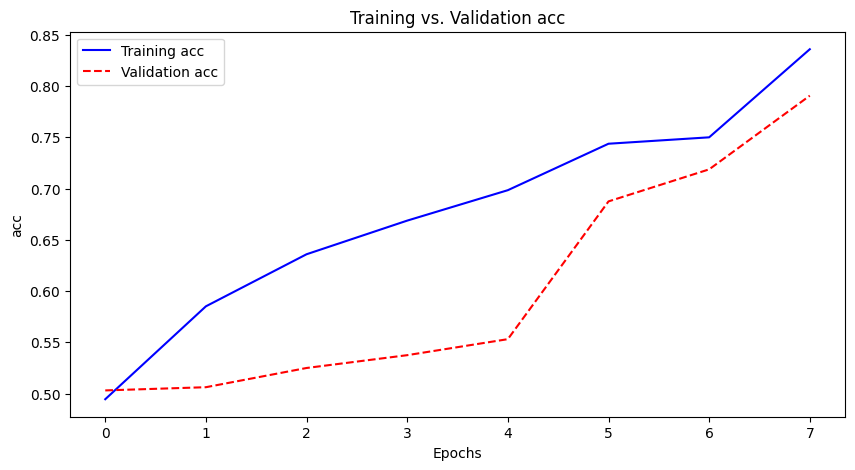

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - acc: 0.8037 - loss: 0.4835
#Test accuracy:0.805


In [29]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.optimizers import Adam

# Enable eager execution
# tf.config.run_eagerly(True)


model = Sequential([
    Embedding(max_words, 64),
    Bidirectional(LSTM(64)), # simple RNN 대신 bidirectional LSTM을 사용
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.summary()

adam = Adam(learning_rate=1e-4)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['acc'])

history = model.fit(X_train, y_train,
                    epochs=8,
                    verbose=1,
                    validation_split=0.2)

plot_results(history, 'acc')

#테스트 셋으로 학습된 모형의 성능을 평가
score = model.evaluate(X_test, y_test)
print(f'#Test accuracy:{score[1]:.3f}')

In [30]:
y_pred = np.round(model.predict(X_test[:10]))
for pred, y_t in zip(y_pred, y_test[:10]):
    print(f'predicted value: {pred[0]}, true value: {y_t}, so the prediction is {pred[0] == y_t}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
predicted value: 1.0, true value: 0, so the prediction is False
predicted value: 0.0, true value: 1, so the prediction is False
predicted value: 1.0, true value: 1, so the prediction is True
predicted value: 0.0, true value: 0, so the prediction is True
predicted value: 1.0, true value: 1, so the prediction is True
predicted value: 1.0, true value: 1, so the prediction is True
predicted value: 0.0, true value: 0, so the prediction is True
predicted value: 1.0, true value: 0, so the prediction is False
predicted value: 0.0, true value: 0, so the prediction is True
predicted value: 0.0, true value: 0, so the prediction is True
